## 使用CNN 辨识 CIFAR10 资料集
#### 程式修改自[‘TRAINING A CLASSIFIER’](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

## 载入套件

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

## 判断是否使用GPU

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
"cuda" if torch.cuda.is_available() else "cpu"

'cuda'

## 载入资料集

In [3]:
# 资料转换
transform = transforms.Compose(
    [transforms.ToTensor(),
     # 读入图像范围介于[0, 1]之间，将之转换为 [-1, 1]
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     # ImageNet
     # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

# 批量
batch_size = 1000

# 载入资料集，如果出现 BrokenPipeError 错误，将 num_workers 改为 0
train_ds = torchvision.datasets.CIFAR10(root='./CIFAR10', train=True,
                                        download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

test_ds = torchvision.datasets.CIFAR10(root='./CIFAR10', train=False,
                                       download=True, transform=transform)

test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# 训练/测试资料的维度
print(train_ds.data.shape, test_ds.data.shape)

Files already downloaded and verified
Files already downloaded and verified
(50000, 32, 32, 3) (10000, 32, 32, 3)


## 资料集共10种类别

In [4]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## 显示图片资料

torch.Size([8, 3, 32, 32])


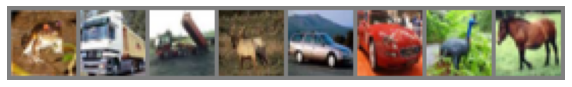

frog  truck truck deer  car   car   bird  horse


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# 图像显示函数
def imshow(img):
    img = img * 0.5 + 0.5  # 还原图像
    npimg = img.numpy()
    # 颜色换至最后一维
    plt.imshow(np.transpose(npimg, (1, 2, 0))) 
    plt.axis('off')
    plt.show()


# 取一笔资料
batch_size_tmp = 8
train_loader_tmp = torch.utils.data.DataLoader(train_ds, batch_size=batch_size_tmp)
dataiter = iter(train_loader_tmp)
images, labels = dataiter.next()
print(images.shape)

# 显示图像
plt.figure(figsize=(10,6))
imshow(torchvision.utils.make_grid(images))
# 显示类别
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size_tmp)))

## 建立CNN模型

In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # 颜色要放在第1维，3:RGB三颜色
        self.conv1 = nn.Conv2d(3, 6, 5) 
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
#         output = F.log_softmax(x, dim=1)
        return x

## 训练模型

In [7]:
def train(model, device, train_loader, criterion, optimizer, epoch):
    model.train()
    loss_list = []    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        if (batch_idx+1) % 10 == 0:
            loss_list.append(loss.item())
            batch = (batch_idx+1) * len(data)
            data_count = len(train_loader.dataset)
            percentage = (100. * (batch_idx+1) / len(train_loader))
            print(f'Epoch {epoch}: [{batch:5d} / {data_count}] ' +
                  f'({percentage:.0f} %)  Loss: {loss.item():.6f}')
    return loss_list

In [8]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            correct += (predicted == target).sum().item()

    # 平均损失
    test_loss /= len(test_loader.dataset) 
    # 显示测试结果
    data_count = len(test_loader.dataset)
    percentage = 100. * correct / data_count 
    print(f'准确率: {correct}/{data_count} ({percentage:.2f}%)')

In [9]:
epochs = 10
lr=0.1

# 建立模型
model = Net().to(device)

# 定义损失函数
# 注意，nn.CrossEntropyLoss是类别，要先建立物件，要加 ()，其他损失函数不需要
criterion = nn.CrossEntropyLoss() # F.nll_loss 

# 设定优化器(optimizer)
#optimizer = torch.optim.Adadelta(model.parameters(), lr=lr)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

loss_list = []
for epoch in range(1, epochs + 1):
    loss_list += train(model, device, train_loader, criterion, optimizer, epoch)
    #test(model, device, test_loader)
    #optimizer.step()

Epoch 1: [10000 / 50000] (20 %)  Loss: 2.305822
Epoch 1: [20000 / 50000] (40 %)  Loss: 2.300462
Epoch 1: [30000 / 50000] (60 %)  Loss: 2.286949
Epoch 1: [40000 / 50000] (80 %)  Loss: 2.138572
Epoch 1: [50000 / 50000] (100 %)  Loss: 2.027645
Epoch 2: [10000 / 50000] (20 %)  Loss: 1.895739
Epoch 2: [20000 / 50000] (40 %)  Loss: 1.861227
Epoch 2: [30000 / 50000] (60 %)  Loss: 1.794352
Epoch 2: [40000 / 50000] (80 %)  Loss: 1.735934
Epoch 2: [50000 / 50000] (100 %)  Loss: 1.613504
Epoch 3: [10000 / 50000] (20 %)  Loss: 1.587622
Epoch 3: [20000 / 50000] (40 %)  Loss: 1.597150
Epoch 3: [30000 / 50000] (60 %)  Loss: 1.570795
Epoch 3: [40000 / 50000] (80 %)  Loss: 1.540450
Epoch 3: [50000 / 50000] (100 %)  Loss: 1.508678
Epoch 4: [10000 / 50000] (20 %)  Loss: 1.416559
Epoch 4: [20000 / 50000] (40 %)  Loss: 1.356395
Epoch 4: [30000 / 50000] (60 %)  Loss: 1.400068
Epoch 4: [40000 / 50000] (80 %)  Loss: 1.407507
Epoch 4: [50000 / 50000] (100 %)  Loss: 1.334789
Epoch 5: [10000 / 50000] (20 %)  Los

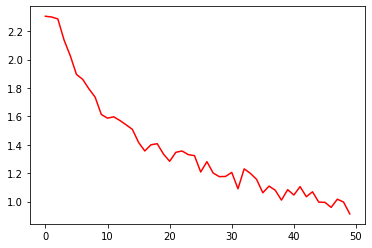

In [10]:
# 对训练过程的损失绘图
import matplotlib.pyplot as plt

plt.plot(loss_list, 'r')

## 模型存档

In [42]:
PATH = './cifar_net.pth'
torch.save(model.state_dict(), PATH)

In [43]:
model = Net()
model.load_state_dict(torch.load(PATH))
model.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

## 评分

In [44]:
test(model, device, test_loader)

准确率: 5731/10000 (57.31%)


## 测试一批资料

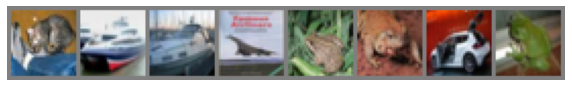

真实类别:  cat   ship  ship  plane frog  frog  car   frog 
预测类别:  cat   car   car   ship  deer  frog  car   frog 


In [51]:
batch_size=8
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size)
dataiter = iter(test_loader)
images, labels = dataiter.next()

# 显示图像
plt.figure(figsize=(10,6))
imshow(torchvision.utils.make_grid(images))

print('真实类别: ', ' '.join(f'{classes[labels[j]]:5s}' 
                         for j in range(batch_size)))

# 预测
outputs = model(images.to(device))

_, predicted = torch.max(outputs, 1)

print('预测类别: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(batch_size)))

## 计算各类别的准确率

In [52]:
# 初始化各类别的正确数
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# 预测
batch_size=1000
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size)
model.eval()
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        _, predictions = torch.max(outputs, 1)
        # 计算各类别的正确数
        for label, prediction in zip(target, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# 计算各类别的准确率
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'{classname:5s}: {accuracy:.1f} %')

plane: 41.1 %
car  : 66.8 %
bird : 50.0 %
cat  : 27.5 %
deer : 51.5 %
dog  : 30.5 %
frog : 72.8 %
horse: 74.0 %
ship : 76.6 %
truck: 82.3 %
